# Quora Question Pairs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print(train.shape)
print(test.shape)

(404290, 6)
(3563475, 3)


In [0]:
train.sample()

,id,qid1,qid2,question1,question2,is_duplicate
378246,378246,13789,130847,What are the pros and cons of masturbation?,How harmful or unhealthy is masturbation?,1


In [0]:
test.sample()

,test_id,question1,question2
2317227,2317227,What were the causes sourav which the Marathas...,Did the defeat of Marathas in the third battle...


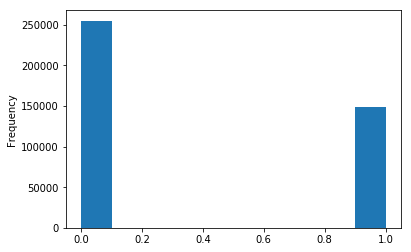

In [0]:
train['is_duplicate'].plot.hist();

In [0]:
percent = train['is_duplicate'].mean()*100
print('The percentage of duplicate in train set is {0:.4g}%'.format(percent))

The percentage of duplicate in train set is 36.92%


In [0]:
train_qs = pd.Series(train['question1'].tolist()+train['question2'].tolist()).astype(str)
train_qs.dtypes

dtype('O')

In [0]:
from collections import Counter
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)

In [0]:
counts.most_common(20)

[('the', 376234),
 ('what', 310963),
 ('is', 268849),
 ('how', 219019),
 ('i', 213185),
 ('a', 210233),
 ('to', 204067),
 ('in', 194724),
 ('of', 158912),
 ('do', 154720),
 ('are', 145405),
 ('and', 132755),
 ('can', 113819),
 ('for', 101512),
 ('you', 84648),
 ('why', 75548),
 ('my', 70759),
 ('best', 69692),
 ('it', 60806),
 ('on', 59407)]

# Tokenization and stopwords removal

In [0]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess #text processing

In [0]:
sentences = train_qs.tolist()
sentences = filter(None, sentences) # remove empty strings
#sentences = list(map(remove_stopwords,sentences)) #clean text 
sentences = list(map(simple_preprocess,sentences)) #clean text 

In [0]:
stoplist = set('for a of the and to in on it is by'.split())
sentences = [[word for word in sentence if word not in stoplist]
          for sentence in sentences]

# Stemming

In [0]:
from nltk.stem.snowball import SnowballStemmer 
snowball = SnowballStemmer("english")
stem_tokens = []

for sentence in sentences:
    s = []
    for word in sentence:
        s.append(snowball.stem(word))
    stem_tokens.append(s)

In [0]:
import pickle
#pickle.dump(stem_tokens, open('stem_tokens.txt','wb'))
stem_tokens = pickle.load(open('stem_tokens.txt','rb'))

# Lemmatization

In [0]:
from nltk.corpus import wordnet as wn
import nltk

def get_wn_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return ''

In [0]:
sentence_pos = [nltk.pos_tag(sentence) for sentence in sentences]

In [0]:
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()
lemma_tokens = []

for sentence in sentence_pos:
    s = []
    for pair in sentence:
        if  get_wn_pos(pair[1]) != '':
            s.append(wnl.lemmatize(pair[0], get_wn_pos(pair[1])))
        else:
            s.append(wnl.lemmatize(pair[0]))
    lemma_tokens.append(s)

In [0]:
#pickle.dump(lemma_tokens, open('lemma_tokens.txt','wb'))
lemma_tokens = pickle.load(open('lemma_tokens.txt','rb'))

# TF-IDF Model

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer()
vect_word = TfidfVectorizer(lowercase=True,analyzer='word',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(lowercase=True,analyzer='char',ngram_range=(3,6),dtype=np.float32)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_qs)
#tfidf_word_matrix = vect_word.fit_transform(train_qs)
#tfidf_char_matrix = vect_char.fit_transform(train_qs)

In [0]:
tfidf_word_matrix.shape

(808580, 2825037)

In [0]:
tfidf_char_matrix.shape

(808580, 2539587)

In [0]:
import time
tfidf_pred = []
start_time = time.time()
for i in range(404290):
    score = cosine_similarity(tfidf_matrix[i], tfidf_matrix[404290+i])
    tfidf_pred.append(score[0][0])
print("--- %s seconds ---" % (time.time() - start_time))

--- 397.88549399375916 seconds ---


In [0]:
import pickle
#pickle.dump(tfidf_matrix, open('tfidf_matrix.txt','wb'))
#pickle.dump(tfidf_word_matrix, open('tfidf_word_matrix.txt','wb'))
#pickle.dump(tfidf_char_matrix, open('tfidf_char_matrix.txt','wb'))
#pickle.dump(tfidf_pred, open('tfidf_pred.txt','wb'))
tfidf_matrix = pickle.load(open('tfidf_matrix.txt','rb'))
tfidf_pred = pickle.load(open('tfidf_pred.txt','rb'))
tfidf_word_matrix = pickle.load(open('tfidf_word_matrix.txt','rb'))
tfidf_char_matrix = pickle.load(open('tfidf_char_matrix.txt','rb'))

In [0]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
print('TF-IDF log_loss:', log_loss(train['is_duplicate'], tfidf_pred))
print('TF-IDF accuracy:', accuracy_score(train['is_duplicate'], 
                                         list(map(lambda x: round(x), tfidf_pred))))

TF-IDF log_loss: 0.6935975038373786
TF-IDF accuracy: 0.6631180588191644


# Logistic Regression on TF-IDF

In [0]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
X = hstack([tfidf_word_matrix[0:404290], tfidf_char_matrix[0:404290], 
            tfidf_word_matrix[404290:], tfidf_char_matrix[404290:]])
y = train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.25)

In [0]:
import time
start_time = time.time()
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
logistic_pred = clf.predict(X_valid)
logistic_pre_proba = clf.predict_proba(X_valid)
print('Logistic Regression log_loss:', log_loss(y_valid, logistic_pre_proba))
print('Logistic Regression accuracy:', accuracy_score(y_valid, logistic_pred))
print("--- %s seconds ---" % (time.time() - start_time))

Logistic Regression log_loss: 0.45962586286656026
Logistic Regression accuracy: 0.7896371929199687


# XGBoost on TF-IDF

In [0]:
X = hstack([tfidf_matrix[0:404290], tfidf_matrix[404290:]])
y = train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.25)

In [0]:
import time
start_time = time.time()
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', eta=0.2, max_depth=5)
eval_set = [(X_valid, y_valid)]
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
xgb_pred_proba = xgb_model.predict_proba(X_valid)
print('XGBoost Classifier accuracy:', accuracy_score(y_valid, list(map(lambda x: round(x[1]), xgb_pred_proba))))
print("--- %s seconds ---" % (time.time() - start_time))

[0]	validation_0-logloss:0.683144
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.675001
[2]	validation_0-logloss:0.668339
[3]	validation_0-logloss:0.662732
[4]	validation_0-logloss:0.658121
[5]	validation_0-logloss:0.654272
[6]	validation_0-logloss:0.650987
[7]	validation_0-logloss:0.647992
[8]	validation_0-logloss:0.645429
[9]	validation_0-logloss:0.64325
[10]	validation_0-logloss:0.641247
[11]	validation_0-logloss:0.639446
[12]	validation_0-logloss:0.637895
[13]	validation_0-logloss:0.636513
[14]	validation_0-logloss:0.635184
[15]	validation_0-logloss:0.634017
[16]	validation_0-logloss:0.632879
[17]	validation_0-logloss:0.631886
[18]	validation_0-logloss:0.630873
[19]	validation_0-logloss:0.630008
[20]	validation_0-logloss:0.628983
[21]	validation_0-logloss:0.62824
[22]	validation_0-logloss:0.627401
[23]	validation_0-logloss:0.62657
[24]	validation_0-logloss:0.625885
[25]	validation_0-logloss:0.625214
[26]	validation_0-logloss:0.624456


[230]	validation_0-logloss:0.572483
[231]	validation_0-logloss:0.572362
[232]	validation_0-logloss:0.572224
[233]	validation_0-logloss:0.572072
[234]	validation_0-logloss:0.571942
[235]	validation_0-logloss:0.571806
[236]	validation_0-logloss:0.571703
[237]	validation_0-logloss:0.571593
[238]	validation_0-logloss:0.571457
[239]	validation_0-logloss:0.57133
[240]	validation_0-logloss:0.571224
[241]	validation_0-logloss:0.57112
[242]	validation_0-logloss:0.571025
[243]	validation_0-logloss:0.570867
[244]	validation_0-logloss:0.570727
[245]	validation_0-logloss:0.570607
[246]	validation_0-logloss:0.570479
[247]	validation_0-logloss:0.570351
[248]	validation_0-logloss:0.570231
[249]	validation_0-logloss:0.570121
[250]	validation_0-logloss:0.570022
[251]	validation_0-logloss:0.569889
[252]	validation_0-logloss:0.569777
[253]	validation_0-logloss:0.569665
[254]	validation_0-logloss:0.569571
[255]	validation_0-logloss:0.569445
[256]	validation_0-logloss:0.569309
[257]	validation_0-logloss:0.5

[459]	validation_0-logloss:0.550919
[460]	validation_0-logloss:0.550849
[461]	validation_0-logloss:0.550794
[462]	validation_0-logloss:0.550718
[463]	validation_0-logloss:0.550661
[464]	validation_0-logloss:0.550595
[465]	validation_0-logloss:0.550546
[466]	validation_0-logloss:0.550492
[467]	validation_0-logloss:0.550437
[468]	validation_0-logloss:0.550371
[469]	validation_0-logloss:0.550299
[470]	validation_0-logloss:0.550218
[471]	validation_0-logloss:0.550137
[472]	validation_0-logloss:0.550027
[473]	validation_0-logloss:0.54994
[474]	validation_0-logloss:0.549871
[475]	validation_0-logloss:0.549805
[476]	validation_0-logloss:0.549722
[477]	validation_0-logloss:0.549653
[478]	validation_0-logloss:0.549593
[479]	validation_0-logloss:0.549537
[480]	validation_0-logloss:0.549452
[481]	validation_0-logloss:0.549384
[482]	validation_0-logloss:0.549302
[483]	validation_0-logloss:0.549236
[484]	validation_0-logloss:0.549178
[485]	validation_0-logloss:0.549102
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.538078
[689]	validation_0-logloss:0.538
[690]	validation_0-logloss:0.537957
[691]	validation_0-logloss:0.537913
[692]	validation_0-logloss:0.537845
[693]	validation_0-logloss:0.537787
[694]	validation_0-logloss:0.537738
[695]	validation_0-logloss:0.537702
[696]	validation_0-logloss:0.537652
[697]	validation_0-logloss:0.537615
[698]	validation_0-logloss:0.537575
[699]	validation_0-logloss:0.537523
[700]	validation_0-logloss:0.537465
[701]	validation_0-logloss:0.537429
[702]	validation_0-logloss:0.537377
[703]	validation_0-logloss:0.537324
[704]	validation_0-logloss:0.537265
[705]	validation_0-logloss:0.537229
[706]	validation_0-logloss:0.537178
[707]	validation_0-logloss:0.537128
[708]	validation_0-logloss:0.537087
[709]	validation_0-logloss:0.537056
[710]	validation_0-logloss:0.537018
[711]	validation_0-logloss:0.536987
[712]	validation_0-logloss:0.536949
[713]	validation_0-logloss:0.536898
[714]	validation_0-logloss:0.536861
[715]	validation_0-logloss:0.53

KeyboardInterrupt: 

In [0]:
pickle.dump(xgb_model, open('xgb_model_tfidf.sav','wb'))
xgb_model = pickle.load(xgb_model, open('xgb_model_tfidf.sav','rb'))

# XGBoost on CountVector

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
q1 = count_vectorizer.fit_transform(train['question1'].values.astype('U'))
q2 = count_vectorizer.fit_transform(train['question2'].values.astype('U'))
X = hstack([q1, q2])
y = train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.25)

In [0]:
import time
start_time = time.time()
import xgboost as xgb
xgb_model2 = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', eta=0.2, max_depth=5)
eval_set = [(X_valid, y_valid)]
xgb_model2.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", 
               eval_set=eval_set, verbose=True)
xgb_pred_proba2 = xgb_model2.predict_proba(X_valid)
print('XGBoost Classifier accuracy:', accuracy_score(y_valid, list(map(lambda x: round(x[1]), xgb_pred_proba2))))
print("--- %s seconds ---" % (time.time() - start_time))

[0]	validation_0-logloss:0.682447
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.673643
[2]	validation_0-logloss:0.666415
[3]	validation_0-logloss:0.659639
[4]	validation_0-logloss:0.654746
[5]	validation_0-logloss:0.65001
[6]	validation_0-logloss:0.644668
[7]	validation_0-logloss:0.641027
[8]	validation_0-logloss:0.637941
[9]	validation_0-logloss:0.634756
[10]	validation_0-logloss:0.6322
[11]	validation_0-logloss:0.630116
[12]	validation_0-logloss:0.627946
[13]	validation_0-logloss:0.626118
[14]	validation_0-logloss:0.624476
[15]	validation_0-logloss:0.623025
[16]	validation_0-logloss:0.620979
[17]	validation_0-logloss:0.619017
[18]	validation_0-logloss:0.617163
[19]	validation_0-logloss:0.615885
[20]	validation_0-logloss:0.614673
[21]	validation_0-logloss:0.613088
[22]	validation_0-logloss:0.612221
[23]	validation_0-logloss:0.610657
[24]	validation_0-logloss:0.609603
[25]	validation_0-logloss:0.608584
[26]	validation_0-logloss:0.607583


[230]	validation_0-logloss:0.532699
[231]	validation_0-logloss:0.532569
[232]	validation_0-logloss:0.532381
[233]	validation_0-logloss:0.532261
[234]	validation_0-logloss:0.532159
[235]	validation_0-logloss:0.532011
[236]	validation_0-logloss:0.531849
[237]	validation_0-logloss:0.531695
[238]	validation_0-logloss:0.531528
[239]	validation_0-logloss:0.531391
[240]	validation_0-logloss:0.531223
[241]	validation_0-logloss:0.531106
[242]	validation_0-logloss:0.530913
[243]	validation_0-logloss:0.530665
[244]	validation_0-logloss:0.53051
[245]	validation_0-logloss:0.530334
[246]	validation_0-logloss:0.530188
[247]	validation_0-logloss:0.530029
[248]	validation_0-logloss:0.529877
[249]	validation_0-logloss:0.529625
[250]	validation_0-logloss:0.529513
[251]	validation_0-logloss:0.529439
[252]	validation_0-logloss:0.529315
[253]	validation_0-logloss:0.529143
[254]	validation_0-logloss:0.52904
[255]	validation_0-logloss:0.528928
[256]	validation_0-logloss:0.528845
[257]	validation_0-logloss:0.5

[459]	validation_0-logloss:0.507679
[460]	validation_0-logloss:0.507591
[461]	validation_0-logloss:0.507524
[462]	validation_0-logloss:0.507458
[463]	validation_0-logloss:0.507407
[464]	validation_0-logloss:0.507343
[465]	validation_0-logloss:0.507282
[466]	validation_0-logloss:0.507248
[467]	validation_0-logloss:0.507204
[468]	validation_0-logloss:0.507168
[469]	validation_0-logloss:0.507098
[470]	validation_0-logloss:0.507032
[471]	validation_0-logloss:0.506988
[472]	validation_0-logloss:0.506911
[473]	validation_0-logloss:0.506847
[474]	validation_0-logloss:0.506782
[475]	validation_0-logloss:0.506746
[476]	validation_0-logloss:0.506696
[477]	validation_0-logloss:0.506619
[478]	validation_0-logloss:0.506534
[479]	validation_0-logloss:0.5065
[480]	validation_0-logloss:0.506465
[481]	validation_0-logloss:0.506137
[482]	validation_0-logloss:0.506096
[483]	validation_0-logloss:0.506038
[484]	validation_0-logloss:0.505908
[485]	validation_0-logloss:0.505848
[486]	validation_0-logloss:0.5

[688]	validation_0-logloss:0.492093
[689]	validation_0-logloss:0.492005
[690]	validation_0-logloss:0.491972
[691]	validation_0-logloss:0.491936
[692]	validation_0-logloss:0.491915
[693]	validation_0-logloss:0.491889
[694]	validation_0-logloss:0.491828
[695]	validation_0-logloss:0.491784
[696]	validation_0-logloss:0.491741
[697]	validation_0-logloss:0.491718
[698]	validation_0-logloss:0.491654
[699]	validation_0-logloss:0.491619
[700]	validation_0-logloss:0.491575
[701]	validation_0-logloss:0.491536
[702]	validation_0-logloss:0.491513
[703]	validation_0-logloss:0.491476
[704]	validation_0-logloss:0.491397
[705]	validation_0-logloss:0.491367
[706]	validation_0-logloss:0.491316
[707]	validation_0-logloss:0.491287
[708]	validation_0-logloss:0.491262
[709]	validation_0-logloss:0.491098
[710]	validation_0-logloss:0.491038
[711]	validation_0-logloss:0.490999
[712]	validation_0-logloss:0.490958
[713]	validation_0-logloss:0.490296
[714]	validation_0-logloss:0.490247
[715]	validation_0-logloss:0

[917]	validation_0-logloss:0.481056
[918]	validation_0-logloss:0.481032
[919]	validation_0-logloss:0.481009
[920]	validation_0-logloss:0.480994
[921]	validation_0-logloss:0.480976
[922]	validation_0-logloss:0.480945
[923]	validation_0-logloss:0.480909
[924]	validation_0-logloss:0.480856
[925]	validation_0-logloss:0.480828
[926]	validation_0-logloss:0.480784
[927]	validation_0-logloss:0.48075
[928]	validation_0-logloss:0.480712
[929]	validation_0-logloss:0.480673
[930]	validation_0-logloss:0.480647
[931]	validation_0-logloss:0.480564
[932]	validation_0-logloss:0.480538
[933]	validation_0-logloss:0.480517
[934]	validation_0-logloss:0.480501
[935]	validation_0-logloss:0.480482
[936]	validation_0-logloss:0.480456
[937]	validation_0-logloss:0.480449
[938]	validation_0-logloss:0.480368
[939]	validation_0-logloss:0.480346
[940]	validation_0-logloss:0.480327
[941]	validation_0-logloss:0.480317
[942]	validation_0-logloss:0.480282
[943]	validation_0-logloss:0.480265
[944]	validation_0-logloss:0.

# KerasClassifier Model

In [5]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['question1'].astype(str))
tokenizer.fit_on_texts(train['question2'].astype(str))
q1 = tokenizer.texts_to_sequences(train['question1'].astype(str))
q2 = tokenizer.texts_to_sequences(train['question2'].astype(str))

Using TensorFlow backend.


In [0]:
from keras.preprocessing.sequence import pad_sequences
# pad input sequences
max_length1 = max([len(seq) for seq in q1])
seqs1 = pad_sequences(q1, maxlen=max_length1, padding='pre')
max_length2 = max([len(seq) for seq in q2])
seqs2 = pad_sequences(q2, maxlen=max_length2, padding='pre')

In [0]:
import keras
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
num_classes = 2
X = np.concatenate([seqs1, seqs2], axis=1)
scaler = RobustScaler()
X = scaler.fit_transform(X)
y=train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify=y, test_size=0.25)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [0]:
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=364, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=256, verbose=1)
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
model.fit(X_train, y_train, batch_size=128, nb_epoch=100, verbose=1, callbacks=[earlyStopping], 
          validation_data=(X_valid, y_valid), shuffle=True)

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 303217 samples, validate on 101073 samples
Epoch 1/100
303217/303217 [==============================] - 19s 61us/step - loss: 0.6376 - acc: 0.6467 - val_loss: 0.6057 - val_acc: 0.6708
Epoch 2/100
303217/303217 [==============================] - 18s 61us/step - loss: 0.6043 - acc: 0.6751 - val_loss: 0.6018 - val_acc: 0.6772
Epoch 3/100
303217/303217 [==============================] - 17s 57us/step - loss: 0.5995 - acc: 0.6812 - val_loss: 0.5947 - val_acc: 0.6805
Epoch 4/100
303217/303217 [==============================] - 18s 60us/step - loss: 0.5956 - acc: 0.6851 - val_loss: 0.5941 - val_acc: 0.6836
Epoch 5/100
303217/303217 [==============================] - 21s 68us/step - loss: 0.5928 - acc: 0.6863 - val_loss: 0.5919 - val_acc: 0.6860
Epoch 6/100
303217/303217 [==============================] - 21s 69us/step - loss: 0.5884 - acc: 0.6858 - val_loss: 0.5872 - val_acc: 0.6808
Epoch 7/100
303217/303217 [==============================] - 21s 69us/step - loss: 0.5851 - acc: 0.685

# Doc2Vec Model

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]

In [0]:
d2v_model = Doc2Vec(window=3, min_count=2, workers=4, alpha=0.025, min_alpha=0.025)
d2v_model.build_vocab(documents)

In [0]:
import time
start_time = time.time()
for epoch in range(10):
    d2v_model.train(documents, total_examples=len(documents), epochs=1)
    d2v_model.alpha -= 0.002                # decrease the learning rate
    d2v_model.min_alpha = model.alpha       # fix the learning rate, no decay
print("--- %s seconds ---" % (time.time() - start_time))

--- 567.3281860351562 seconds ---


In [0]:
d2v_model.save('doc2vec.model')
d2v_model = Doc2Vec.load('doc2vec.model')

In [0]:
d2v_model.docvecs.most_similar(positive=[model.infer_vector(sentences[0])],topn=5)

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(0, 0.563169002532959),
 (602108, 0.5296576023101807),
 (108486, 0.5231451392173767),
 (404290, 0.5165294408798218),
 (739041, 0.5136462450027466)]

In [0]:
d2v_model.docvecs.n_similarity([0], [404290])

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.89288795

In [0]:
doc2vec_pred = []
for i in range(404290):
    score = d2v_model.docvecs.similarity(i, 404290+i)
    doc2vec_pred.append(score)

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print('Doc2Vec log_loss:', log_loss(train['is_duplicate'], doc2vec_pred))
print('Doc2Vec accuracy:', accuracy_score(train['is_duplicate'], list(map(lambda x: round(x), doc2vec_pred))))

Doc2Vec AUC: 0.7028003809431244
Doc2Vec accuracy: 0.6583492047787479


# Word2Vec Model

In [0]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences, window=3, min_count=2, workers=4, alpha=0.025, min_alpha=0.025)

In [0]:
import time
start_time = time.time()
for epoch in range(10):
    w2v_model.train(sentences, total_examples=len(sentences), epochs=1)
    w2v_model.alpha -= 0.002                # decrease the learning rate
    w2v_model.min_alpha = w2v_model.alpha       # fix the learning rate, no decay
print("--- %s seconds ---" % (time.time() - start_time))

--- 64.77591300010681 seconds ---


In [0]:
#w2v_model.save('word2vec.zmodel.sav')
w2v_model = Word2Vec.load('word2vec.model')

In [0]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in index2word_set:
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [0]:
len(w2v_model.wv['india'])

In [0]:
word2vec_pred = []
num_features = 100 
for i in range(404290):
    q1_avg_vector = avg_sentence_vector(sentences[0+i], w2v_model, num_features, 
                                        w2v_model.wv.vocab).reshape(1,-1)
    q2_avg_vector = avg_sentence_vector(sentences[404290+i], w2v_model, num_features, 
                                        w2v_model.wv.vocab).reshape(1,-1)
    score = cosine_similarity(q1_avg_vector,q2_avg_vector)
    word2vec_pred.append(score[0][0])

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [0]:
print('Word2Vec log_loss:', log_loss(train['is_duplicate'], word2vec_pred))
print('Word2Vec accuracy:', accuracy_score(train['is_duplicate'], list(map(lambda x: round(x), word2vec_pred))))
# AUC: lemma > token > stem

Word2Vec AUC: 0.7248271912128748
Word2Vec accuracy: 0.5244700586212867
